In [2]:
import sys
sys.path.insert(1, 'C:/Users/raena/Documents/Imperial College London/msc_thesis/code/functions_and_classes')

from dataRead import *
from glob import glob
import pandas as pd
import numpy as np

## Check EQW over whole period

In [3]:
# Get DJI Index weights data per quarter

DJI_weights_paths = glob('../../data/dataBBG/DJI_index_weights/DJI_*.pickle')
DJI_weights_per_quarter = {}
for path in DJI_weights_paths:
    date = path.split('.')[-2].split('_')[-1]
    DJI_weights_per_quarter[date] = pd.read_pickle(path)

# Import price and volume data for each stock in the DJI Index
DJI_PX_LAST_paths = glob('../../data/dataBBG/DJI_stock_PX_LAST/* Equity.pickle')
DJI_PX_VOLUME_paths = glob('../../data/dataBBG/DJI_stock_PX_VOLUME/* Equity.pickle')

DJI_price_data = {}
DJI_volume_data = {}

for path in DJI_PX_LAST_paths:
    ticker = (' ').join(path.split('.')[-2].split('\\')[-1].split(' ')[0:1])
    # if ticker == '3277Q UN': # JP Morgan
    #     path = '../../data/dataBBG/DJI_stock_PX_LAST/JPM UN Equity.pickle'
    df = pd.read_pickle(path).set_index('date')
    df.index = pd.to_datetime(df.index)
    DJI_price_data[ticker] = df

for path in DJI_PX_VOLUME_paths:
    ticker = (' ').join(path.split('.')[-2].split('\\')[-1].split(' ')[0:1])
    df = pd.read_pickle(path).set_index('date')
    df.index = pd.to_datetime(df.index)
    # df.index = pd.to_datetime(df.index)
    DJI_volume_data[ticker] = df

trading_days = pd.to_datetime(list(DJI_price_data['AAPL'].index))

# Matrix Conditioning (RMT)

N = 5, 6,..., 60

In [4]:
from covarianceMatrixVolume import *
from thresholdVectors import *
from tqdm import tqdm
qDates = list(DJI_weights_per_quarter.keys())
n_q = len(qDates)

k = -1
dat = qDates[k-4]
datend = str(int(qDates[k]) - 1)
weights_data = DJI_weights_per_quarter[dat]
members = weights_data.sort_values(by = 'Weight', ascending = False)['INDX_MWEIGHT_HIST'].iloc[:10]
prices = pd.DataFrame({ticker: DJI_price_data[ticker]['PX_LAST'] for ticker in DJI_price_data.keys()})
volumes = pd.DataFrame({ticker: DJI_volume_data[ticker]['PX_VOLUME'] for ticker in DJI_price_data.keys()})
tempR = np.log(prices.loc[str(dat):str(datend),members]).diff(1).iloc[1:] # log returns
tempV = volumes.loc[str(dat):str(datend),members].iloc[1:] 
tempV = np.log(tempV)
tempV = (tempV - tempV.mean(axis=0))/tempV.std(axis = 0, ddof=1)
print(tempR.shape)

(251, 10)


In [5]:
class ConditionNumbers():

    def __init__(self,
                DJI_weights_per_quarter,
                DJI_price_data,
                DJI_volume_data,
                trad_days):
        self.DJI_weights_per_quarter = DJI_weights_per_quarter
        self.DJI_price_data = DJI_price_data
        self.DJI_volume_data = DJI_volume_data
        self.trad_days = trad_days


    def get_eigen_and_conditions(
        self,
        qDates,
        cRList = [0.5],
        cVList = [0],
        nStart = 15,
        nEnd = 60,
        K = 20,
        DJI_weights_per_quarter = DJI_weights_per_quarter,
        DJI_price_data = DJI_price_data,
        DJI_volume_data = DJI_volume_data,
        trad_days = trading_days):

        self.qDates = qDates
        self.cRList = cRList
        self.cVList = cVList
        self.nStart = nStart
        self.nEnd = nEnd
        self.K = K
        covKeys = ['HIS', 'LW']
        for cR in self.cRList:
            for cV in self.cVList:
                covKeys += [f'GS1_{cR}_{cV}', f'GS2_{cR}_{cV}']
        conditionRes = {N: {k : {} for k in covKeys} for N in range(self.nStart, self.nEnd + 1)}
        minEigRes = {N: {k : {} for k in covKeys} for N in range(self.nStart, self.nEnd + 1)}
        for qDate in tqdm(qDates, position = 0, leave = True):
            covMatrices = self.get_matrices_length_N(qDate)
            for covKey in covKeys:
                mat = covMatrices[covKey]
                for N in np.arange(self.nStart, self.nEnd + 1):
                    matN = mat[N]
                    if np.isnan(matN).sum().sum() == 0 and np.isinf(matN).sum().sum() == 0:
                        cN = self.conditionNumber(matN)
                        minEig = np.real(np.linalg.eig(matN)[0]).min()
                    else:
                        cN = None
                        minEig = None
                    conditionRes[N][covKey][qDate] = cN
                    minEigRes[N][covKey][qDate] = minEig
        return conditionRes, minEigRes

    def get_matrices_length_N(
        self,
        qDate):
        nDictReturns, nDictVolume = self.get_data_length_N(qDate)
        matrixDict = {'HIS' : {}, 'LW': {}}
        for cR in self.cRList:
            for cV in self.cVList:
                matrixDict[f'GS1_{cR}_{cV}'] = {}
                matrixDict[f'GS2_{cR}_{cV}'] = {}
        for N in np.arange(self.nStart, self.nEnd + 1):
            tempR = nDictReturns[N]
            tempV = nDictVolume[N]
            covMatInst = CovarianceMatrixVolume(returnsMatrix = tempR, volumeMatrix = tempV)

            HIS = covMatInst.historicalCovariance()[0]
            LW  = covMatInst.ledoitWolf()[0]
            matrixDict['HIS'][N] = HIS
            matrixDict['LW'][N] = LW
            
            for cR in self.cRList:
                for cV in self.cVList:
                    key1 = f'GS1_{cR}_{cV}'
                    key2 = f'GS2_{cR}_{cV}'
                    rThreshold = ThresholdVectors(tempR).standard_deviation(c = cR)
                    vThreshold = ThresholdVectors(tempV).standard_deviation(c = cV)
                    GS1 = covMatInst.GerberMatrix1(rThreshold, vThreshold, method = 'quick')[0]
                    GS2 = covMatInst.GerberMatrix2(rThreshold, vThreshold, method = 'quick')[0]
                    matrixDict[key1][N] = GS1
                    matrixDict[key2][N] = GS2

        return matrixDict

    def get_data_length_N(
        self,
        qDate):
        nDictReturns = {}
        nDictVolume = {}
        weights_data = self.DJI_weights_per_quarter[qDate]
        members = weights_data.sort_values(by = 'Weight', ascending = False).iloc[0:self.K]['INDX_MWEIGHT_HIST']
        prices = pd.DataFrame({ticker: self.DJI_price_data[ticker]['PX_LAST'] for ticker in DJI_price_data.keys()})
        volumes = pd.DataFrame({ticker: self.DJI_volume_data[ticker]['PX_VOLUME'] for ticker in DJI_price_data.keys()})
        for N in np.arange(self.nStart, self.nEnd + 1):
            trading_dates = self.get_trading_dates(qDate, N + 1)
            tempR = np.log(prices.loc[trading_dates,members]).diff(1).iloc[1:] # log returns
            tempV = volumes.loc[trading_dates,members].iloc[1:] 
            tempV = (tempV - tempV.mean(axis=0))/tempV.std(axis = 0, ddof=1)
            nDictReturns[N] = tempR
            nDictVolume[N] = tempV
        return nDictReturns, nDictVolume
        
    def get_trading_dates(self, start_date, N):
        pos = np.where(self.trad_days >= start_date)[0][0]
        posN = pos + N
        trading_dates = self.trad_days[pos:posN]
        return trading_dates

    def conditionNumber(self, mat):
        eigenvalues, eigenvectors = np.linalg.eig(mat)
        return np.abs(np.max(eigenvalues)/np.min(eigenvalues))

In [6]:
cInst = ConditionNumbers(DJI_weights_per_quarter,
                        DJI_price_data,
                        DJI_volume_data,
                        trading_days)

res10 = cInst.get_eigen_and_conditions(qDates[15:-4], K = 10)
res20 = cInst.get_eigen_and_conditions(qDates[15:-4], K = 20)
res30 = cInst.get_eigen_and_conditions(qDates[15:-4], K = 30)

100%|██████████| 82/82 [02:53<00:00,  2.11s/it]


* N = 15, 20, 30, 50

In [7]:
def format_tex(float_number):
    # function courtesy of: https://stackoverflow.com/questions/13490292/format-number-using-latex-notation-in-python
    neg = False
    if float_number == 0.0:
        return r"$0.0"
    elif float_number < 0.0:
        neg = True

    exponent = np.floor(np.log10(abs(float_number)))
    mantissa = float_number/10**exponent
    if neg:
        mantissa = -mantissa
    mantissa_format = str(mantissa)[0:3]
    return "${0}\\times10^{{{1}}}$".format(mantissa_format, str(int(exponent)))

# N = 10
resDict = res10[0]
stdDict = {}
for T in [15,20,30,60]:
    df = pd.DataFrame(resDict[T])
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    stdDict[T] = df.std(ddof = 1, skipna = True)

df = pd.DataFrame(stdDict).T
df.columns = ['HIS','LW','GS1','GS2']
df = df.applymap(lambda x:format_tex(x))
print(df.to_latex())


# N = 30
resDict = res30[0]
stdDict = {}
for T in [15,20,30,60]:
    df = pd.DataFrame(resDict[T])
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    stdDict[T] = df.std(ddof = 1, skipna = True)

df = pd.DataFrame(stdDict).T
df.columns = ['HIS','LW','GS1','GS2']
df = df.applymap(lambda x:format_tex(x))
print(df.to_latex())

\begin{tabular}{lllll}
\toprule
 & HIS & LW & GS1 & GS2 \\
\midrule
15 & $3.5\times10^{2}$ & $9.7\times10^{0}$ & $5.9\times10^{16}$ & $5.4\times10^{16}$ \\
20 & $8.8\times10^{1}$ & $1.1\times10^{1}$ & $4.3\times10^{16}$ & $1.1\times10^{16}$ \\
30 & $5.0\times10^{1}$ & $1.2\times10^{1}$ & $4.7\times10^{1}$ & $7.5\times10^{0}$ \\
60 & $4.5\times10^{1}$ & $1.7\times10^{1}$ & $1.9\times10^{1}$ & $6.7\times10^{0}$ \\
\bottomrule
\end{tabular}

\begin{tabular}{lllll}
\toprule
 & HIS & LW & GS1 & GS2 \\
\midrule
15 & $6.7\times10^{15}$ & $4.8\times10^{1}$ & $1.2\times10^{16}$ & $3.6\times10^{17}$ \\
20 & $8.0\times10^{15}$ & $5.3\times10^{1}$ & $1.4\times10^{16}$ & $3.2\times10^{18}$ \\
30 & $3.9\times10^{18}$ & $6.5\times10^{1}$ & $2.4\times10^{17}$ & $6.0\times10^{17}$ \\
60 & $4.9\times10^{17}$ & $7.3\times10^{1}$ & $1.2\times10^{17}$ & $8.0\times10^{16}$ \\
\bottomrule
\end{tabular}



In [34]:
(pd.DataFrame(res30[0][60])['GS2_0.5_0']>10_000).sum()

11

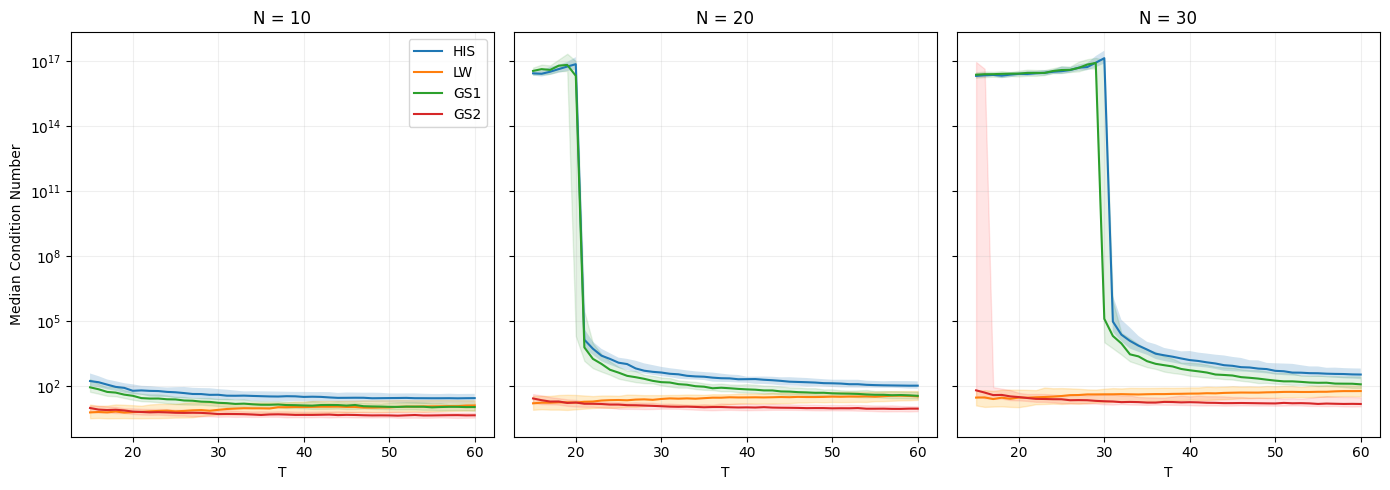

In [15]:
from matplotlib import pyplot as plt

nStart = 15
nEnd = 60

fpFig = '../../code/figures'

def getDFs(resDict, nStart = 15, nEnd = 60, qUp = 0.75, qDn = 0.25):
    medDict = {}
    sUDict = {}
    sDDict = {}
    for N in np.arange(nStart, nEnd + 1):
        s = pd.DataFrame(resDict[N]).median()
        sU = pd.DataFrame(resDict[N]).quantile(qUp)
        sD = pd.DataFrame(resDict[N]).quantile(qDn)
        medDict[N] = s
        sUDict[N] = sU
        sDDict[N] = sD

    df = pd.DataFrame(medDict).T
    sUdf = pd.DataFrame(sUDict).T
    sDdf = pd.DataFrame(sDDict).T
    return [df, sUdf, sDdf]


fig, ax = plt.subplots(1,3, figsize = (14,5), sharey = True)

def interval_line_plots(ax, dfList, N, hide_legend = False, logscale = True):
    df, sUdf, sDdf = dfList
    ax.plot(df)
    if logscale:
        ax.set_yscale('log')
    ax.fill_between(x = sUdf.index, y1 = sUdf['HIS'], y2 = sDdf['HIS'], alpha = 0.2, label = 'HIS')
    ax.fill_between(x = sUdf.index, y1 = sUdf['LW'], y2 = sDdf['LW'], alpha = 0.2, color = 'orange', label = 'LW')
    ax.fill_between(x = sUdf.index, y1 = sUdf['GS1_0.5_0'], y2 = sDdf['GS1_0.5_0'], alpha = 0.1, color = 'green', label = 'GS1')
    ax.fill_between(x = sUdf.index, y1 = sUdf['GS2_0.5_0'], y2 = sDdf['GS2_0.5_0'], alpha = 0.1, color = 'red', label = 'GS2')
    ax.grid(alpha = 0.2)
    if not hide_legend:
        ax.legend(labels = ['HIS','LW','GS1','GS2'])
    ax.set_xlabel('T')
    ax.set_title(f'N = {N}')
    return ax

interval_line_plots(ax[0], getDFs(res10[0]), N = 10, hide_legend = False)
interval_line_plots(ax[1], getDFs(res20[0]), N = 20, hide_legend = True)
interval_line_plots(ax[2], getDFs(res30[0]), N = 30, hide_legend = True)
ax[0].set_ylabel('Median Condition Number')
fig.tight_layout()
fig.savefig(f'{fpFig}/condition_medians_1.pdf', bbox_inches='tight')

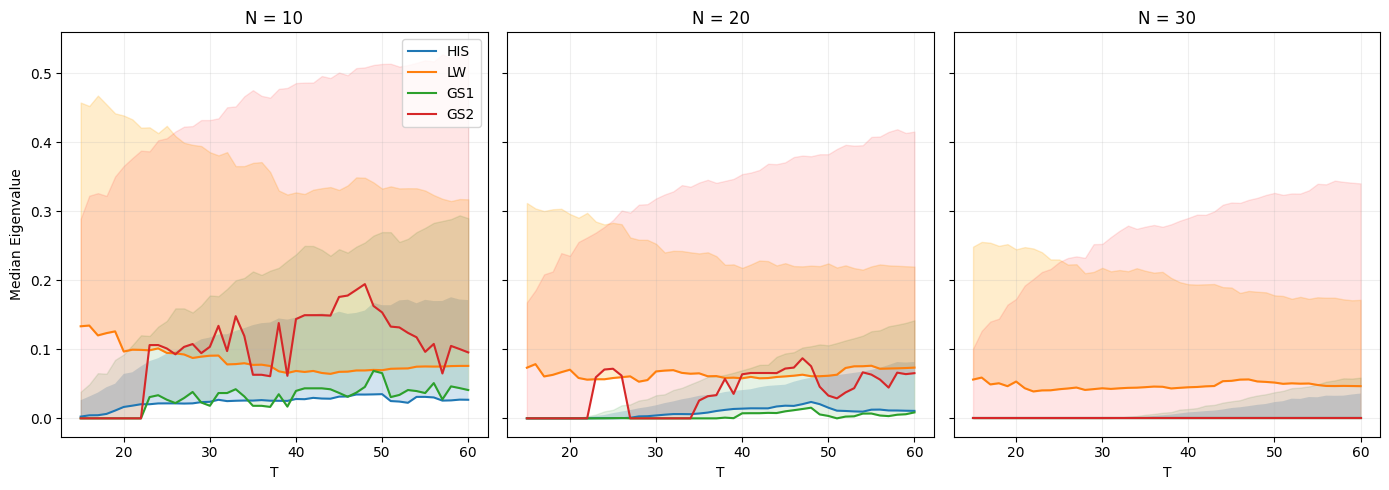

In [35]:
fig, ax = plt.subplots(1,3, figsize = (14,5), sharey = True)
def getDFs(resDict, nStart = 15, nEnd = 60, qUp = 0.5, qDn = 0):
    medDict = {}
    sUDict = {}
    sDDict = {}
    for N in np.arange(nStart, nEnd + 1):
        s = pd.DataFrame(resDict[N]).min()
        sU = pd.DataFrame(resDict[N]).quantile(qUp)
        sD = pd.DataFrame(resDict[N]).quantile(qDn)
        medDict[N] = s
        sUDict[N] = sU
        sDDict[N] = sD

    df = pd.DataFrame(medDict).T
    sUdf = pd.DataFrame(sUDict).T
    sDdf = pd.DataFrame(sDDict).T
    return [df, sUdf, sDdf]
interval_line_plots(ax[0], getDFs(res10[1]), N = 10, hide_legend = False, logscale = False)
interval_line_plots(ax[1], getDFs(res20[1]), N = 20, hide_legend = True, logscale = False)
interval_line_plots(ax[2], getDFs(res30[1]), N = 30, hide_legend = True, logscale = False)
ax[0].set_ylabel('Median Eigenvalue')
fig.tight_layout()